In [ ]:
!pip install mapie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 1.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/CARS/tabular_data.csv', index_col=0)

In [ ]:
# Python code to preprocess every column of a DataFrame by replacing NaNs with the mean of the column
import pandas as pd
from sklearn.impute import SimpleImputer

# Assuming 'df' is your DataFrame
# df = pd.read_csv('your_data.csv')  # Example to load a DataFrame

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to our data frame
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [ ]:
df = df_imputed


In [ ]:

df = df.sample(frac = 1, random_state = 1)

X = df.drop("trojan", axis=1).to_numpy()
y = df["trojan"].to_numpy()


scaler = StandardScaler()
X = scaler.fit_transform(X)

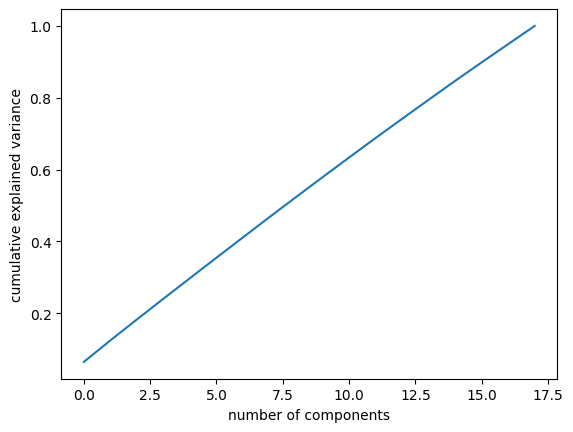

In [ ]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

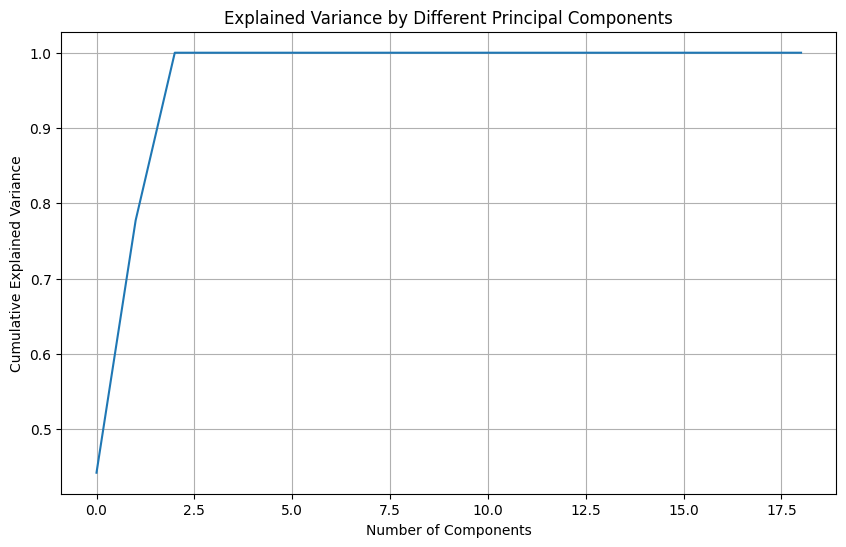

In [ ]:
# Preprocess the DataFrame to replace NaN values with the mean
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
pc = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Separating features for PCA (assuming no specific target column)
X = pc

# Calculating PCA for various number of components
pca = PCA()
pca.fit(X)

# Cumulative explained variance ratio as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.grid(True)
plt.show()

In [ ]:
X = df.drop("trojan", axis=1).to_numpy()
y = df["trojan"].to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=12)
pca.fit(X)
X = pca.transform(X)

In [ ]:
# We use a two-dimensional toy dataset with three labels. The distribution of
# the data is a bivariate normal with diagonal covariance matrices for each
# label.
'''
centers = [(0, 3.5), (-2, 0), (2, 0)]
covs = [np.eye(2), np.eye(2)*2, np.diag([5, 1])]
x_min, x_max, y_min, y_max, step = -6, 8, -6, 8, 0.1
n_samples = 1000
n_classes = 3
np.random.seed(42)
X = np.vstack([
    np.random.multivariate_normal(center, cov, n_samples)
    for center, cov in zip(centers, covs)
])
y = np.hstack([np.full(n_samples, i) for i in range(n_classes)])


'''


X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=0.2
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=0.25
)


# Actual Code

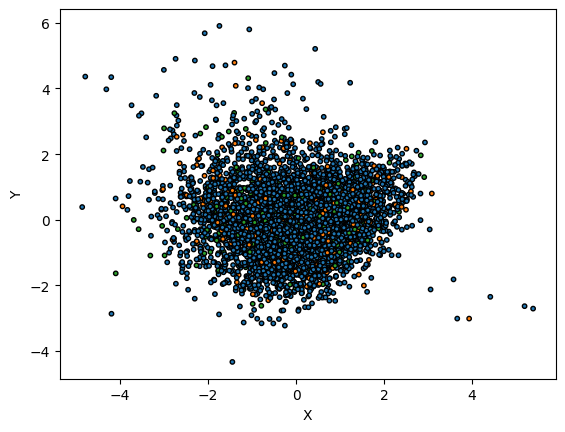

In [ ]:
colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
y_train_col = list(map(colors.get, y_train))
fig = plt.figure()
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    color=y_train_col,
    marker='o',
    s=10,
    edgecolor='k'
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [ ]:


clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba_max = np.max(y_pred_proba, axis=1)
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
mapie_score.fit(X_cal, y_cal)
alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)


In [ ]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=400,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

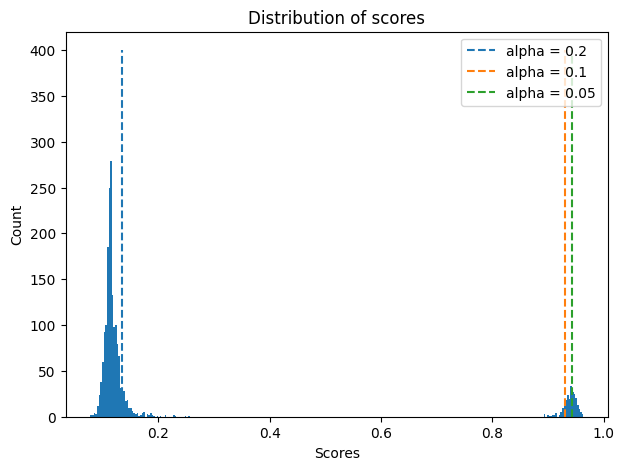

In [ ]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_
plot_scores(n, alpha, scores, quantiles)

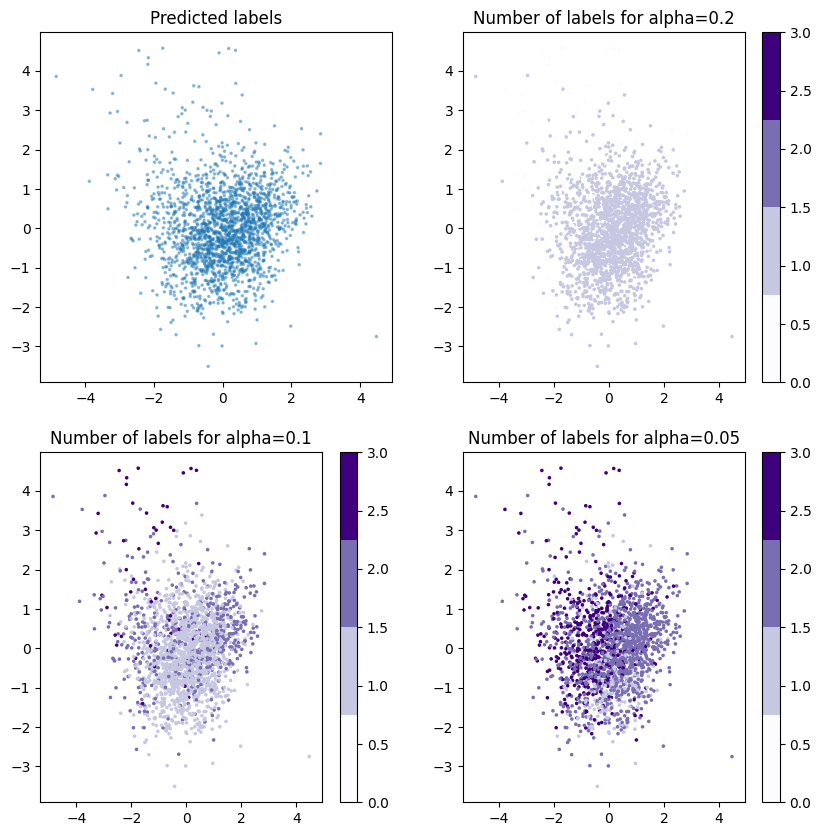

In [ ]:

def plot_results(alphas, X, y_pred, y_ps):
    tab10 = plt.cm.get_cmap('Purples', 4)
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
    y_pred_col = list(map(colors.get, y_pred))
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))
    axs = {0: ax1, 1: ax2, 2:  ax3, 3: ax4}
    axs[0].scatter(
        X[:, 0],
        X[:, 1],
        color=y_pred_col,
        marker='.',
        s=10,
        alpha=0.4
    )
    axs[0].set_title("Predicted labels")
    for i, alpha in enumerate(alphas):
        y_pi_sums = y_ps[:, :, i].sum(axis=1)
        num_labels = axs[i+1].scatter(
            X[:, 0],
            X[:, 1],
            c=y_pi_sums,
            marker='.',
            s=10,
            alpha=1,
            cmap=tab10,
            vmin=0,
            vmax=3
        )
        plt.colorbar(num_labels, ax=axs[i+1])
        axs[i+1].set_title(f"Number of labels for alpha={alpha}")
    plt.show()


plot_results(alpha, X_test, y_pred_score, y_ps_score)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

X_train, X_rest1, y_train, y_rest1 = train_test_split(
X, y, train_size=500, random_state=2
)
# From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(
X_rest1, y_rest1, train_size=400, random_state=42
)
# Split remaining into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(
X_rest2, y_rest2, train_size=200, random_state=42
)

# Fit the model
model = LogisticRegression(random_state=0).fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix
# Check accuracy
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm))

Accuracy: 0.905
     0  1  2
0  362  1  0
1   20  0  0
2   17  0  0


In [ ]:
# Setting the alpha so that we get 95% prediction sets
alpha = 0.05
# define quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(scores, q_level)

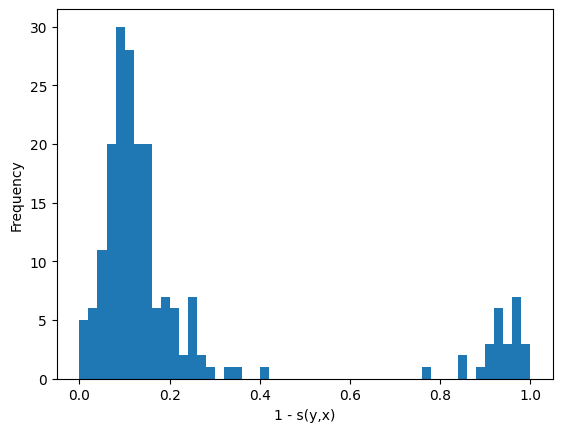

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your existing code
predictions = model.predict_proba(X_calib)

# Check if y_calib is of integer type, convert if necessary
if not np.issubdtype(y_calib.dtype, np.integer):
    y_calib = y_calib.astype(int)

# Ensure y_calib values are within the valid range
if not np.all((y_calib >= 0) & (y_calib < predictions.shape[1])):
    raise ValueError("Values in y_calib are out of bounds")

# Get for each instance the actual probability of ground truth
prob_for_true_class = predictions[np.arange(len(y_calib)), y_calib]

# Create a histogram
plt.hist(1 - prob_for_true_class, bins=50, range=(0, 1))
plt.xlabel("1 - s(y,x)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
prediction_sets = (1 - model.predict_proba(X_new) <= qhat)

In [ ]:
prediction_sets

array([[ True, False, False],
       [ True, False,  True],
       [ True, False, False],
       ...,
       [ True, False,  True],
       [ True,  True, False],
       [ True, False,  True]])

In [ ]:
from mapie.classification import MapieClassifier

# Choose a valid method, e.g., 'score'
cp = MapieClassifier(estimator=model, cv="prefit", method="score")

# Rest of your code
cp.fit(X_calib, y_calib)
y_pred, y_set = cp.predict(X_new, alpha=0.15)
y_set = np.squeeze(y_set)


In [ ]:
# first count number of classes per bean
set_sizes = y_set.sum(axis=1)
# use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts())

1    8518
0     182
dtype: int64


In [ ]:
y_pred, y_set = cp.predict(X_new, alpha=0.05)
# remove the 1-dim dimension
y_set = np.squeeze(y_set)
# first count number of classes per bean
set_sizes = y_set.sum(axis=1)
# use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts())

3    4338
2    3420
1     942
dtype: int64


#CP

In [ ]:
y_set

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True, False,  True],
       [ True,  True,  True],
       [ True, False,  True]])

In [ ]:
y_new

array([0., 0., 0., ..., 1., 0., 0.])

In [ ]:
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
# print('Coverage: {:.2%}'.format(cov))
# print('Avg. set size: {:.2f}'.format(setsize))

In [ ]:
# print(cov)

In [ ]:
from sklearn.metrics import confusion_matrix
# Check accuracy
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm))

Accuracy: 0.905
     0  1  2
0  362  1  0
1   20  0  0
2   17  0  0


In [ ]:
from typing import Any, Dict, List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from typing_extensions import TypedDict

from mapie._typing import NDArray
from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)

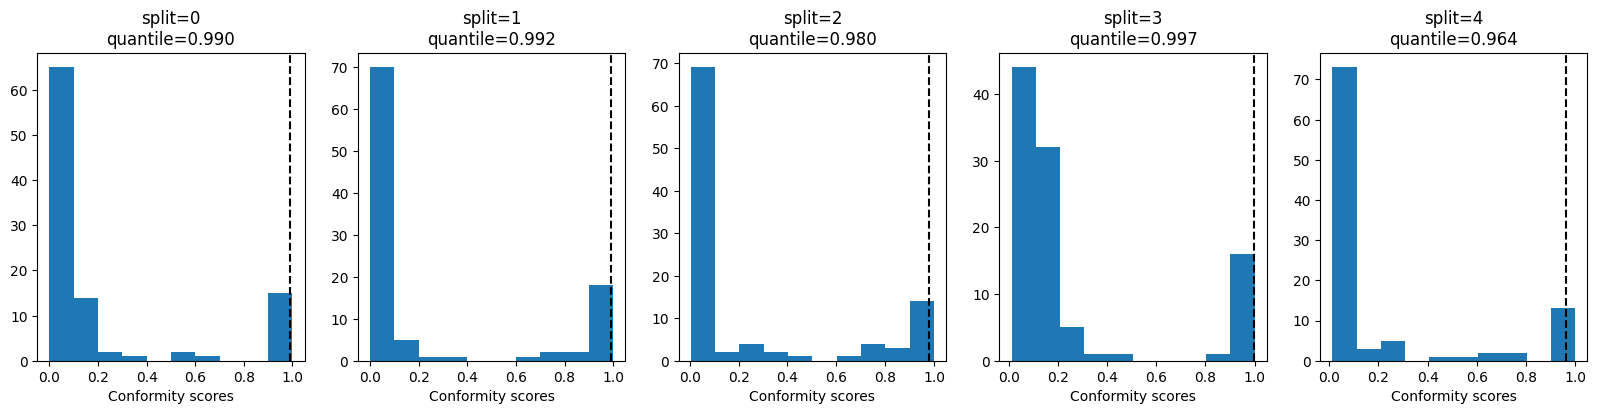

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
clfs, mapies, y_preds, y_ps_mapies = {}, {}, {}, {}
methods = ["score", "cumulated_score"]
alpha = np.arange(0.01, 1, 0.01)
for method in methods:
    clfs_, mapies_, y_preds_, y_ps_mapies_ = {}, {}, {}, {}
    for fold, (train_index, calib_index) in enumerate(kf.split(X_train)):
        clf = GaussianNB().fit(X_train[train_index], y_train[train_index])
        clfs_[fold] = clf
        mapie = MapieClassifier(estimator=clf, cv="prefit", method=method)
        mapie.fit(X_train[calib_index], y_train[calib_index])
        mapies_[fold] = mapie
        y_pred_mapie, y_ps_mapie = mapie.predict(
            X_test, alpha=alpha, include_last_label="randomized"
        )
        y_preds_[fold], y_ps_mapies_[fold] = y_pred_mapie, y_ps_mapie
    clfs[method], mapies[method], y_preds[method], y_ps_mapies[method] = (
        clfs_, mapies_, y_preds_, y_ps_mapies_
    )

fig, axs = plt.subplots(1, len(mapies["score"]), figsize=(20, 4))
for i, (key, mapie) in enumerate(mapies["score"].items()):
    axs[i].set_xlabel("Conformity scores")
    axs[i].hist(mapie.conformity_scores_)
    axs[i].axvline(mapie.quantiles_[9], ls="--", color="k")
    axs[i].set_title(f"split={key}\nquantile={mapie.quantiles_[9]:.3f}")

#plt.suptitle("Distribution of scores on each calibration fold for the "f"{methods[0]} method")
plt.show()
